# Quantum Neural Network (Fashion MNIST) with TensorFlow-Quantum and Cirq

## 1.Dataset

Number of Images in the Train Dataset - 10200

Number of Images in the Validation Dataset - 1800

Number of Images in the Test Dataset - 2000

Size of each Image - (2,2)

Type of Image - Grayscale Image

Number of Labels - 2


~~~
Label	Description
5	    Sandal
9	    Ankle boot
~~~

## 2.Installing required packages

In [135]:
# installing TensorFLow Version 2.3.1
from IPython.display import clear_output
%pip install -q tensorflow==2.3
clear_output()

In [136]:
# install tensorflow quantum
%pip install -q tensorflow_quantum
clear_output()

In [137]:
#install cirq
%pip install cirq
clear_output()

## 3.Importing the dataset and required packages

In [165]:
import tensorflow as tf

# Data Processing tools
import numpy as np
from sklearn.model_selection import train_test_split 

# QML tools
import tensorflow_quantum as tfq
import cirq
import sympy

# Visualization Tools
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

In [ ]:
#Lets print the version of cirq and tfq that we will use
print("We are using the TensorFlow-Quantum version {}".format(tfq.__version__))
print("We are using the Cirq version {}".format(cirq.__version__))

In [167]:
#importing the Fashion MNIST dataset from keras
from tensorflow.keras.datasets import fashion_mnist as dataset

In [168]:
(X_train, y_train), (X_test, y_test) = dataset.load_data()

In [ ]:
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

## 4.Preprocessing the Dataset
We will train and test our model on only 2 types of images to keep it as simple as possible. We will keep only the labels 5 and 9. To make it simpler we will associate boolean values with these labels. So 5 => True, and 9 => False

In [170]:
def filter_data(x, y):
  """
  Helper Function to filter the dataset
  """
  #filter the data using labels
  keep = (y == 5) | (y == 9)
  x, y = x[keep], y[keep]

  # convert labels to boolean
  # y = True if y==5
  # y = False if y==9
  y = y == 5
  return x,y

In [171]:
#Filter the train set
X_train, y_train = filter_data(X_train, y_train)

#Filter the test_set
X_test, y_test = filter_data(X_test, y_test)

In [ ]:
# Let's have a look at the shapes of train and test data
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

In [ ]:
#Let's have a look at the first image from our X_train and the 
# corresponding label from y_train
print("The First Image has the label {}".format(y_train[0]))
print("")
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

From the colorbar in the above visualization, it is clear that we have grayscale images in the dataset and hence their values range from 0 to 255. However, we would like to scale these pixel values in our dataset so that the values range from 0 to 1. This will help us to converge our CNN training faster

In [174]:
#Normalizing the train and test image data
X_train = X_train/255.0
X_test = X_test/ 255.0

In [ ]:
#Let's again have a look at the first image from our X_train and
#see if we have successfully normalized the datasets
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

## 5.Resize The images
From a 28X28 image we will make a 2X2 image

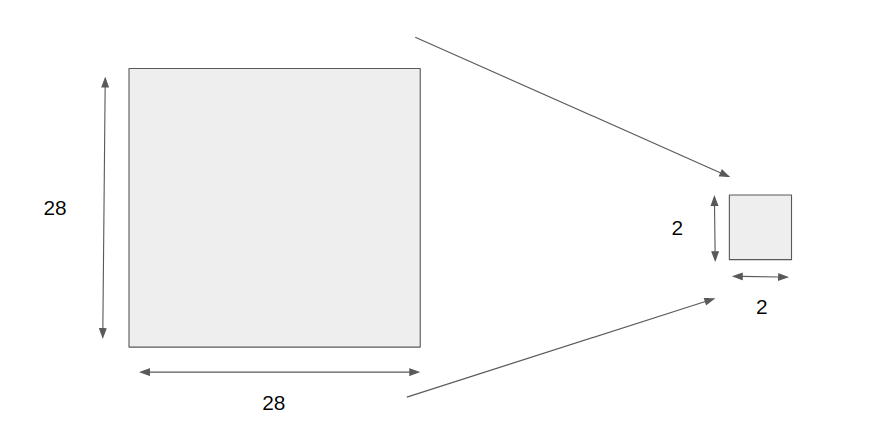


In [176]:
#Before proceeding, we need to reshape our images in the dataset
X_train = X_train.reshape(X_train.shape[0], *(28,28,1))
X_test = X_test.reshape(X_test.shape[0], *(28,28,1))

In [177]:
# Downscaling the images
X_train = tf.image.resize(X_train, (2,2)).numpy()
X_test = tf.image.resize(X_test, (2,2)).numpy()


In [ ]:
#Let's again have a look at the first image from our resized X_train
plt.imshow(X_train[0,:,:,0])
plt.colorbar()
plt.title('Visualization of the Resized Dataset')
plt.show()

In [179]:
#Splitting the training fdataset into train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)

In [ ]:
print("The shape of the X_train is {}".format(X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_valid is {}".format(X_valid.shape))
print("The shape of the y_valid is {}".format(y_valid.shape))

## 6.Data Encoding

Steps involved in Data Encoding:

* Processing pixel values for binary encoding. We will obtain a cirq circuit for each 2x2 image 

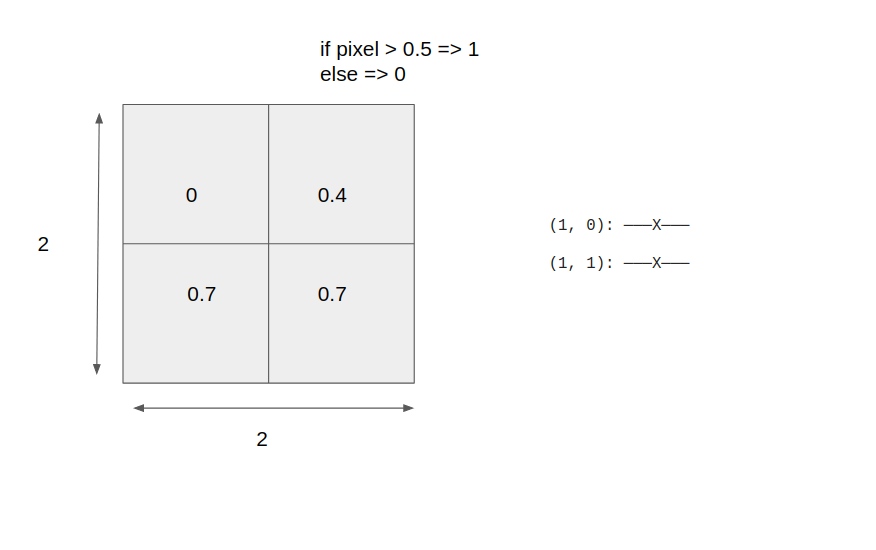

* Converting Cirq Circuits to tfq tensors

**Step 1: Processing Pixel Values for Binary Encoding**

In [144]:
# FLattening the images
X_train = X_train.reshape(X_train.shape[0], *(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0], *(1,4,1))
X_test = X_test.reshape(X_test.shape[0], *(1,4,1))

### 6.a.Processing X_train

In [ ]:
#Let's have a look on the first example
print(X_train[0])

In [181]:

def binary_encode(X,threshold=0.5):
  """
  Encodes the given datset to use binary encoding

  Parameters:
  X(array) : Image data to be processed for encoding
  threshold(float): Threshold for binary encoding, 0.5 by default

  Returns:
  encoded_images(array): Binary encoded Image Data

  """ 
  encoded_images = list()
  for image in X:
    # pixel value is 1 if it's greater than threshold or else zero
    encoded_image = [1 if j>threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)

In [147]:
X_train = binary_encode(X_train)

In [ ]:
# Now, Let's have a look on the first example again
print(X_train[0])

In [ ]:
print("The shape of the X_train is {}".format(X_train.shape))

In [150]:
def create_circuit_from_image(encoded_image):
  """
  Returns a circuit for given encoded image

  Parameters:
  encoded_image (array): Encoded Image

  Returns:
  circuit (cirq.Circuit object): cirq circuit
  """
  qubits = cirq.GridQubit.rect(2,2)
  circuit = cirq.Circuit()
  for i, pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [151]:
X_train = [create_circuit_from_image(encoded_image) for encoded_image in X_train]

In [ ]:
# Let's have a look at the circuit for the first image
print(X_train[0])

Recall that the values for the first image were 0,0,1,1. This implies that we should apply X or NOT gate to the last two qubuts since all the qubits are intially in the 0 states. Applying a X gate will change this state from zero to one. Therefore, we shall apply the X Gate on the last two qubits. We have initialized the four qubits in a rectangular grid. Therefore, the initialized qubits are (0,0), (0,1), (1,0) and (1,1). In the above circuit diagram, note that we have an X gate on the qubits (1,0) and (1,1) which are the last two qubits. Hence, we have successfully created circuit for our image. 

**Step 2: Converting Cirq Circuits to tfq Tensors**

In [153]:
X_train_tfq = tfq.convert_to_tensor(X_train)

### 6.b.Processing X_valid and X_test

In [211]:
X_valid = binary_encode(X_valid)
X_test = binary_encode(X_test)

In [212]:
X_valid = [create_circuit_from_image(encoded_image) for encoded_image in X_valid]
X_test = [create_circuit_from_image(encoded_image) for encoded_image in X_test]

In [213]:
X_valid_tfq = tfq.convert_to_tensor(X_valid)
X_test_tfq = tfq.convert_to_tensor(X_test)

## 7.Quantum Neural Network

### 7.a.Build the QNN

Building the Quantum Neural Network involves two steps

* build a class that adds gates layer by layer

* define the QNN using the class from the above step

In [182]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    def add_singleQubit_gate(self,circuit, gate, qubit_index):
      """
      Adds single qubit gate to the circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      qubits(list): index of qubits to apply the gate 
      Returns:
      None
      """
      for index in qubit_index:
        circuit.append(gate(self.data_qubits[index]))

    def add_twoQubit_gate(self,circuit, gate, qubit_index):
      """
      Adds two qubit gate to the circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      qubits(list): index of qubits to apply the gate
      Returns:
      None
      """
      if len(qubit_index)!=2:
        raise Exception("The length of the list of indices passed for two qubit \
        gate operations must be equal to two")
      circuit.append(gate(self.data_qubits[qubit_index[0]], self.data_qubits[qubit_index[1]]))

    def add_layer(self, circuit, gate, symbol_gate):
      """
      Adds New Gates/Layers to the Circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      symbol_gate(string): symbol for the gate
      Returns:
      None
      """
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)


In [188]:
def create_qnn():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(2,2)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)

    # Add the ising coupling XX gate
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [189]:
qmodel, model_readout = create_qnn()

In [ ]:
#Let's have a look at our Qauntum Circuit that will perform the classification
SVGCircuit(qmodel)

In [201]:
model = tf.keras.Sequential([
                             
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),

    
    # The PQC stands for Paramaterized Quantum Circuit
    # This returns the expectation value
    tfq.layers.PQC(qmodel, model_readout),
])

In [202]:
# To use Hinge Loss, we convert the labels to 1 and -1
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

In [203]:
# Let's have a look at the first label from the training dataset
print(y_train_h[0])

1


In [204]:
# Define the custom Hinge Accuracy
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

### 7.b.Train the QNN

In [205]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy])

In [ ]:
qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid_tfq, y_valid_h))

In [ ]:
model.evaluate(X_test_tfq, y_test_h)

## 8.Visualize the Results

In [ ]:
# Visualize Accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

In [ ]:
# Visualize Loss
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()

## Refernces

* https://www.tensorflow.org/quantum/tutorials/mnist
* https://quantumai.google/cirq/tutorials
* [Paper by Farhi et al.](https://arxiv.org/pdf/1802.06002.pdf)
* [Paper by Dmitri Maslov](https://www.google.com/url?sa=t&source=web&rct=j&url=https://arxiv.org/pdf/1603.07678&ved=2ahUKEwi86KbBlfvuAhUmzDgGHfteCIsQFjAJegQIHhAC&usg=AOvVaw04beRgWLMZhYBV6GpyygHF)